In [4]:
import sys
import os

current_notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root_dir = os.path.abspath(os.path.join(current_notebook_dir, '../../'))

# 将这个父目录添加到sys.path的最前面
if project_root_dir not in sys.path:
    sys.path.insert(0, project_root_dir)

print(sys.path)

['/home/hqdeng7/lijuyang/generalization/loss_distribution', '/home/hqdeng7/.conda/envs/ljy/lib/python311.zip', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11/lib-dynload', '', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11/site-packages', '/tmp/tmp9ph8w00l']


In [5]:
from pytorch_script.visual_utils import load_cifar10_data, \
	get_sorted_model_paths, load_model_state_dict, evaluate_model_performance

In [16]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pickle

def sample_high_loss_images(epoch: int, dataset_type: str = 'test', num_samples: int = 5):
    """
    采样某一epoch中损失最大的图片。

    Args:
        epoch (int): 要加载模型的训练轮次。
        dataset_type (str): 'train' 或 'test'，表示使用训练集或测试集。
        num_samples (int): 返回损失最大的图片数量。

    Returns:
        list: 包含字典的列表，每个字典包含 'loss', 'image', 'true_label', 'predicted_label'。
              按损失降序排列。
    """
    config = config = {
	'model_dir': '../../model_training_results/cifar10_resnet20',  # 模型存储的文件夹路径
	'model_prefix': 'model_',        # 模型文件名的前缀
	'model_extension': '.pth',                         # 保存模型的文件扩展名
	'cifar10_data_path': '../../pytorch_script/data/cifar10',           # CIFAR-10 数据集存储路径
	'batch_size': 64,                                 # DataLoader 的批次大小
	'num_workers': 2                                  # DataLoader 的工作进程数
}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader = load_cifar10_data(
        config['cifar10_data_path'], config['batch_size'], config['num_workers']
    )

    if dataset_type == 'train':
        data_loader = train_loader
        # dataset = train_dataset # 实际这里不需要dataset对象，因为dataloader已经提供了图片和标签
    elif dataset_type == 'test':
        data_loader = test_loader
        # dataset = test_dataset
    else:
        raise ValueError("dataset_type 必须是 'train' 或 'test'")

    if data_loader is None:
        print("数据加载失败。")
        return []

    model_path = os.path.join(config['model_dir'], f"{config['model_prefix']}{epoch}{config['model_extension']}")
    
    if not os.path.exists(model_path):
        print(f"模型文件 {model_path} 不存在。请检查路径和 epoch 是否正确。")
        return []

    model = load_model_state_dict('cifar10', 'resnet20', 10, model_path, device)
    model.eval() 
    model.to(device)

    image_losses = []
    with torch.no_grad(): # 在评估时不计算梯度
        for batch_idx, (images, labels) in enumerate(data_loader):
            images_gpu, labels_gpu = images.to(device), labels.to(device)
            outputs = model(images_gpu)

            # 计算每个样本的损失
            per_sample_loss = torch.nn.functional.cross_entropy(outputs, labels_gpu, reduction='none')
            _, predicted = torch.max(outputs.data, 1)

            for i in range(images.size(0)):
                image_losses.append({
                    'loss': per_sample_loss[i].item(),
                    'image': images[i], # 原始图片张量 (CPU上的Tensor)
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

    # 根据损失值降序排列
    image_losses.sort(key=lambda x: x['loss'], reverse=True)

    # 返回损失最大的 num_samples 张图片
    return image_losses[:num_samples]


In [32]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_high_loss_image(epoch, ds_type, num_samples):
	high_loss_images_data = sample_high_loss_images(epoch, ds_type, num_samples)
	
	mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
	std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

	if high_loss_images_data:
		print(f"Epoch {epoch} top-loss images in " + ds_type +f" set")
		plt.figure(figsize=(15, 5)) # 设置图片大小
		for i, item in enumerate(high_loss_images_data):
			loss = item['loss']
			image_tensor = item['image'] # 这是从 DataLoader 中获取的 (C, H, W) 归一化张量
			true_label = item['true_label']
			predicted_label = item['predicted_label']

			# --- 步骤 1: 反归一化 ---
			image_unnormalized = image_tensor * std + mean
			image_unnormalized = torch.clamp(image_unnormalized, 0, 1)

			# --- 步骤 2: 转换维度并转换为 NumPy 数组以供 Matplotlib 显示 ---
			# Matplotlib 的 imshow 期望 (H, W, C) 格式的 NumPy 数组
			# PyTorch 张量通常是 (C, H, W)，所以需要使用 .permute(1, 2, 0) 来转换维度
			image_display = image_unnormalized.permute(1, 2, 0).cpu().numpy()

			# --- 步骤 3: 使用 Matplotlib 显示图片 ---
			plt.subplot(1, len(high_loss_images_data), i + 1)
			plt.imshow(image_display) # 显示维度正确的 NumPy 数组
			plt.title(f"Loss: {loss:.2f}\nTrue: {true_label}, Pred: {predicted_label}")
			plt.axis('off') # 关闭坐标轴

		plt.tight_layout()
		plt.show()
	else:
		print("未找到高损失图片或数据加载失败。")

正在加载 CIFAR-10 数据集到 ../../pytorch_script/data/cifar10...
CIFAR-10 数据集加载成功！
  从字典中提取模型状态字典...
提取成功
Epoch 400 top-loss images in test set


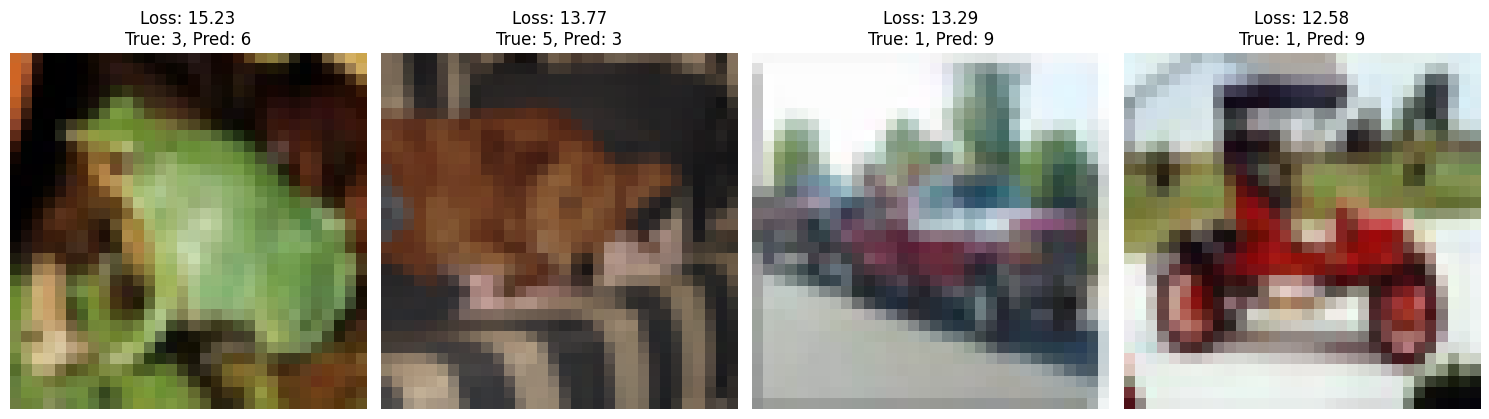

In [33]:
visualize_high_loss_image(400, 'test', 4)